In [ ]:
import numpy as np
import pandas as pd

In [3]:

# Define the column names
column_names = [
    "Aggregate tradeId", "Price", "Quantity", "DollarVolume", "Timestamp", "Was the buyer the maker", "Was the trade the best price match",""
]

# Load the CSV file into a DataFrame
df = pd.read_csv('Data\BTCUSDT-trades-2025-03-01.csv',names=column_names)
# Set 'Aggregate tradeId' as the index
df.set_index('Aggregate tradeId', inplace=True)

df = df.drop('',axis=1)
df = df.drop('Was the trade the best price match',axis=1)
df

,Price,Quantity,DollarVolume,Timestamp,Was the buyer the maker
Aggregate tradeId,,,,,
4624763225,84349.95,0.00181,152.673409,1740787200184756,False
4624763226,84349.95,0.00165,139.177417,1740787200254676,False
4624763227,84349.95,0.00028,23.617986,1740787200506009,False
4624763228,84349.95,0.00028,23.617986,1740787200506211,False
4624763229,84349.95,0.00011,9.278495,1740787200619013,False
...,...,...,...,...,...
4628463948,86064.53,0.00011,9.467098,1740873598545323,True
4628463949,86064.54,0.00020,17.212908,1740873598856604,False
4628463950,86064.53,0.00011,9.467098,1740873599171060,True


In [4]:
df['CumDollarVolume'] = df['DollarVolume'].cumsum()
threshold = 10_000_000
df['counting'] = df['CumDollarVolume']%threshold
df['nth dollar bar'] = df['CumDollarVolume']//threshold
df

,Price,Quantity,DollarVolume,Timestamp,Was the buyer the maker,CumDollarVolume,counting,nth dollar bar
Aggregate tradeId,,,,,,,,
4624763225,84349.95,0.00181,152.673409,1740787200184756,False,1.526734e+02,1.526734e+02,0.0
4624763226,84349.95,0.00165,139.177417,1740787200254676,False,2.918508e+02,2.918508e+02,0.0
4624763227,84349.95,0.00028,23.617986,1740787200506009,False,3.154688e+02,3.154688e+02,0.0
4624763228,84349.95,0.00028,23.617986,1740787200506211,False,3.390868e+02,3.390868e+02,0.0
4624763229,84349.95,0.00011,9.278495,1740787200619013,False,3.483653e+02,3.483653e+02,0.0
...,...,...,...,...,...,...,...,...
4628463948,86064.53,0.00011,9.467098,1740873598545323,True,2.194003e+09,4.003430e+06,219.0
4628463949,86064.54,0.00020,17.212908,1740873598856604,False,2.194003e+09,4.003447e+06,219.0
4628463950,86064.53,0.00011,9.467098,1740873599171060,True,2.194003e+09,4.003456e+06,219.0


In [5]:
# Group by the nth dollar bar and calculate OHLC
ohlc_data = df.groupby('nth dollar bar').agg({
    'Price': ['first', 'max', 'min', 'last'],  # OHLC
    'Timestamp': 'last'  # Use the first timestamp in the group
})

# Flatten the multi-level column index
ohlc_data.columns = ['Open', 'High', 'Low', 'Close', 'Timestamp']

# Reset the index to make 'nth dollar bar' a column
ohlc_data.reset_index(inplace=True)
ohlc_data['Timestamp'] = pd.to_datetime(ohlc_data['Timestamp']/1000,unit='ms', origin='unix')

In [6]:
import mplfinance as mpf  

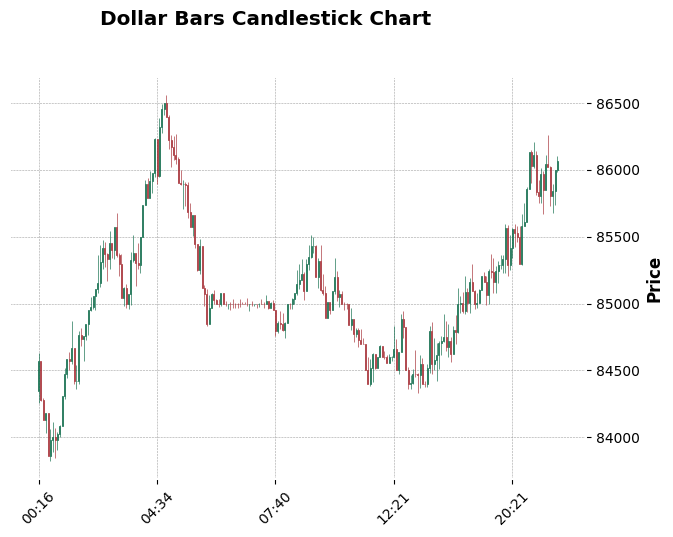

In [7]:

# Set 'Timestamp' as the index
ohlc_data.set_index('Timestamp', inplace=True)

# Plot the candlestick chart
mpf.plot(ohlc_data, type='candle', style='charles', title='Dollar Bars Candlestick Chart', volume=False)

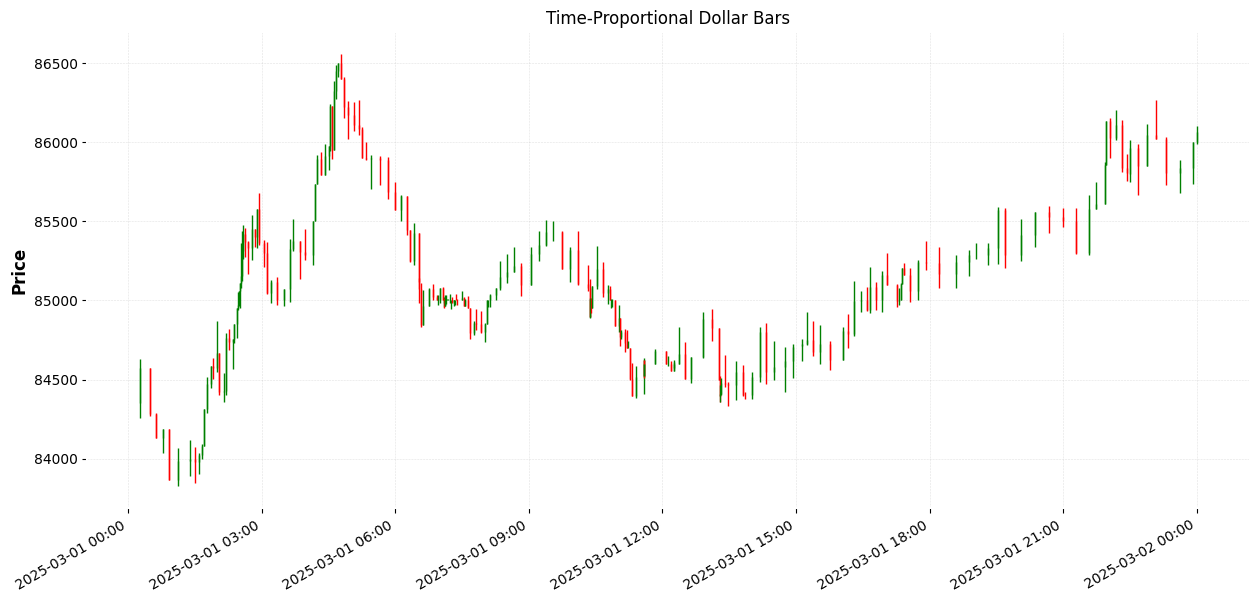

: 

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.patches import Rectangle


# Create figure and axis
fig, ax = plt.subplots(figsize=(15, 7))

# Calculate dynamic width based on time intervals (1/4 of smallest observed interval)
time_diffs = ohlc_data.index.to_series().diff().dt.total_seconds()
min_diff = time_diffs.min() if not time_diffs.empty else 60  # Fallback to 1 minute
width = min_diff / 4 / 86400  # Convert seconds to matplotlib date units

# Plot each candlestick
for idx, (timestamp, row) in enumerate(ohlc_data.iterrows()):
    # Determine color (green for up, red for down)
    color = 'g' if row['Close'] >= row['Open'] else 'r'
    
    # Plot high-low vertical line
    ax.vlines(x=timestamp, 
              ymin=row['Low'], 
              ymax=row['High'], 
              color=color, 
              linewidth=1)
    
    # Create rectangle for open-close body
    rect = Rectangle((mdates.date2num(timestamp) - width/2, min(row['Open'], row['Close'])),
                     width,
                     abs(row['Close'] - row['Open']),
                     facecolor=color,
                     edgecolor=color)
    ax.add_patch(rect)

# Configure time axis
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d %H:%M'))
ax.xaxis_date()  # Interpret x-axis values as dates
fig.autofmt_xdate()

# Add labels and title
plt.ylabel('Price')
plt.title('Time-Proportional Dollar Bars')
plt.grid(True, alpha=0.3)

plt.show()